# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [63]:
np.random.seed(7)
n_samples = 1000


def load_images(n_samples, path):
    filelist = glob.glob(path)
    if n_samples < len(filelist):
        filelist = np.random.choice(filelist, n_samples)
    return np.array([cv2.imread(fname) for fname in filelist])


apple_healty = load_images(n_samples, "images/Apple___healthy/*.JPG") / 255
apple_black_rot = load_images(n_samples, "images/Apple___Black_rot/*.JPG") / 255

print(apple_healty.shape)
print(apple_black_rot.shape)

(1009, 256, 256, 3)
(621, 256, 256, 3)


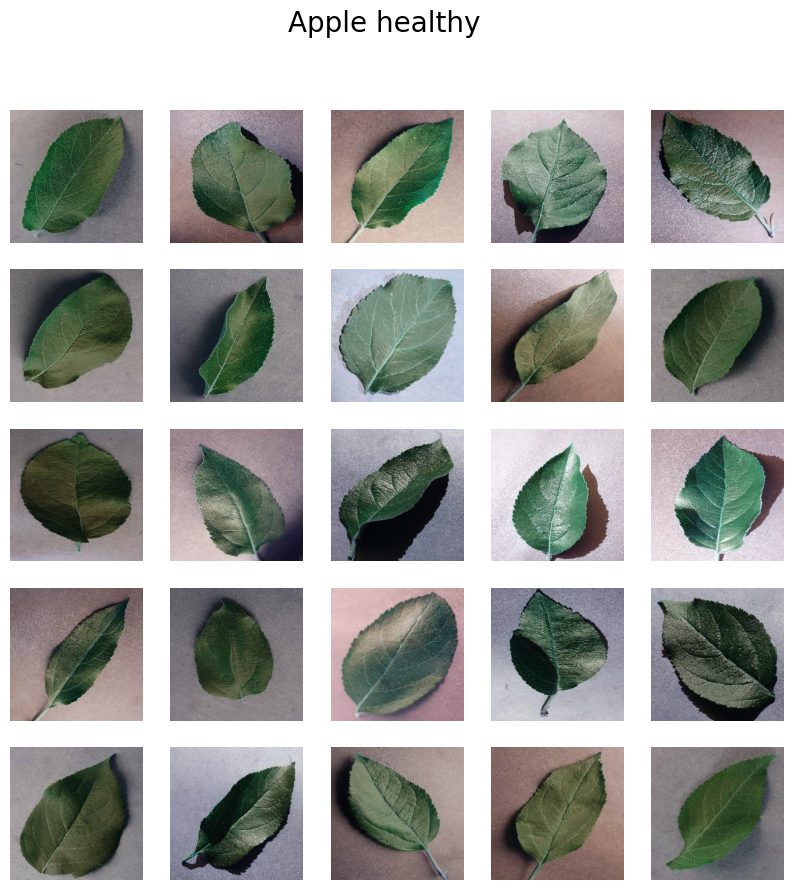

In [64]:
# plot some images in a 5 x 5 grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=20)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

plot_images(apple_healty, "Apple healthy")

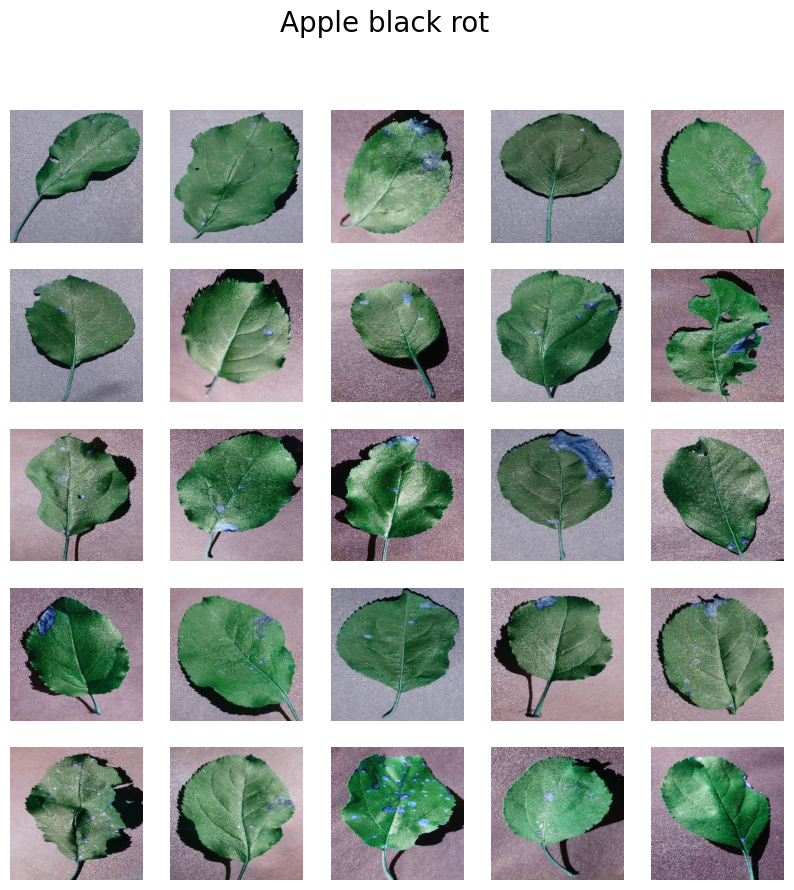

In [65]:
plot_images(apple_black_rot, "Apple black rot")

# TRY VGG16 USING KERAS

In [66]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# create the training and test sets
# use 0 for healthy and 1 for black rot

X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((apple_healty, apple_black_rot)),
    np.concatenate((np.zeros(apple_healty.shape[0]), np.ones(apple_black_rot.shape[0]))),
    test_size=0.2,
    random_state=7,
)

# Preprocessing input using VGG16 preprocessing
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [67]:
from tensorflow.keras.applications.vgg16 import VGG16

# Loading VGG16 model
vgg16_base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
# Disable training for base model
vgg16_base_model.trainable = False 

In [68]:
from tensorflow.keras import layers, models

# Add custom head to vgg16 base model
model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
model.fit(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16, callbacks=[es])


2023-06-23 13:04:16.337898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.5801

2023-06-23 13:04:56.572716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 53s 707ms/step - loss: 0.7088 - accuracy: 0.5801 - val_loss: 0.5807 - val_accuracy: 0.8582


In [70]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test)

11/11 [==============================] - 17s 2s/step - loss: 0.5859 - accuracy: 0.8252


11/11 [==============================] - 11s 1s/step

Confusion Matrix


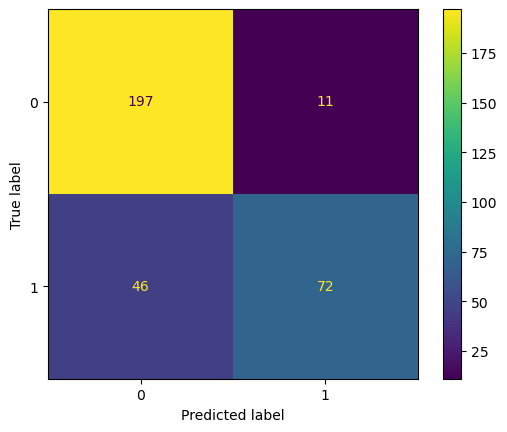


Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87       208
         1.0       0.87      0.61      0.72       118

    accuracy                           0.83       326
   macro avg       0.84      0.78      0.80       326
weighted avg       0.83      0.83      0.82       326



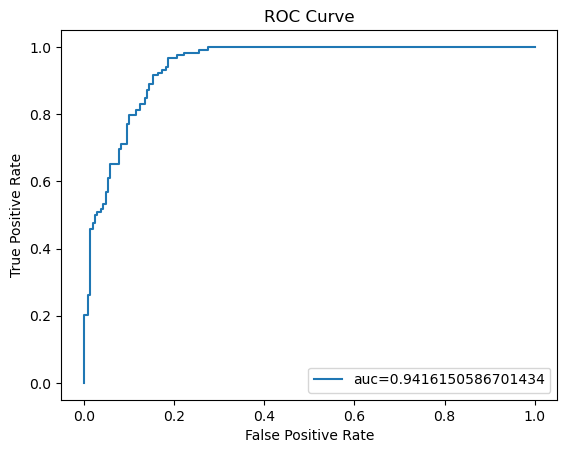

In [76]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

# plot roc curve
y_pred = model.predict(X_test)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

print("\nConfusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_classes), display_labels=[0, 1])
disp.plot()
plt.show()

print("\nClassification Report")
print(classification_report(y_test, y_pred_classes))

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="auc=" + str(roc_auc))
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
